# Quickstart

`geoplot` is a geospatial data visualization library designed for data scientists and geospatial analysts that just want to get things done. In this tutorial we will learn the basics of `geoplot` and see how it is used.

You can run this tutorial code yourself interactively using [Binder](https://mybinder.org/v2/gh/ResidentMario/geoplot/master?filepath=notebooks/tutorials/Quickstart.ipynb).

In [1]:
# Configure matplotlib.
%matplotlib inline

# Unclutter the display.
import pandas as pd; pd.set_option('max_columns', 6)

The starting point for geospatial analysis is geospatial data. The standard way of dealing with such data in Python using `geopandas`&mdash;a geospatial data parsing library over the well-known `pandas` library.

In [2]:
import geopandas as gpd

`geopandas` represents data using a `GeoDataFrame`, which is just a `pandas` `DataFrame` with a special `geometry` column containing a geometric object describing the physical nature of the record in question: a `POINT` in space, a `POLYGON` in the shape of New York, and so on.

In [3]:
import geoplot as gplt
usa_cities = gpd.read_file(gplt.datasets.get_path('usa_cities'))
usa_cities.head()

,id,POP_2010,ELEV_IN_FT,STATE,geometry
0,53,40888.0,1611.0,ND,POINT (-101.2962732 48.23250950000011)
1,101,52838.0,830.0,ND,POINT (-97.03285469999997 47.92525680000006)
2,153,15427.0,1407.0,ND,POINT (-98.70843569999994 46.91054380000003)
3,177,105549.0,902.0,ND,POINT (-96.78980339999998 46.87718630000012)
4,192,17787.0,2411.0,ND,POINT (-102.7896241999999 46.87917560000005)


All functions in `geoplot` take a `GeoDataFrame` as input. To learn more about manipulating geospatial data, see the section [Working with Geospatial Data](https://residentmario.github.io/geoplot/user_guide/Working_with_Geospatial_Data.html).

In [4]:
import geoplot as gplt

If your data consists of a bunch of points, you can display those points using `pointplot`.

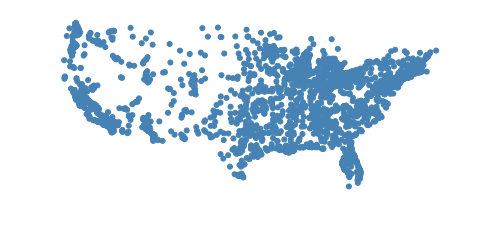

In [5]:
continental_usa_cities = usa_cities.query('STATE not in ["HI", "AK", "PR"]')
gplt.pointplot(continental_usa_cities)

If you have polygonal data instead, you can plot that using a `geoplot` `polyplot`.

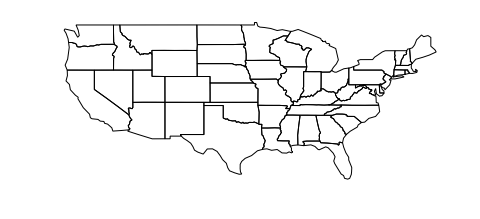

In [6]:
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))
gplt.polyplot(contiguous_usa)

We can combine the these two plots using overplotting. **Overplotting** is the act of stacking several different plots on top of one another, useful for providing additional context for our plots:

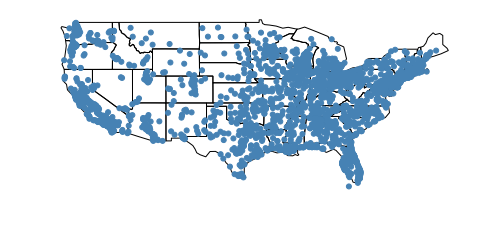

In [7]:
ax = gplt.polyplot(contiguous_usa)
gplt.pointplot(continental_usa_cities, ax=ax)

You might notice that this map of the United States looks very strange. The Earth, being a sphere, is impossible to potray in two dimensionals. Hence, whenever we take data off the sphere and place it onto a map, we are using some kind of **projection**, or method of flattening the sphere. Plotting data without a projection, or "carte blanche", creates distortion in your map. We can "fix" the distortion by picking a better projection.

The Albers equal area projection is one most common in the United States. Here's how you use it with `geoplot`:

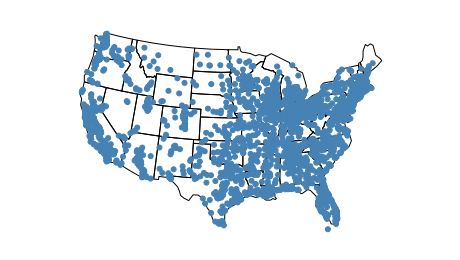

In [8]:
import geoplot.crs as gcrs

ax = gplt.polyplot(contiguous_usa, projection=gcrs.AlbersEqualArea())
gplt.pointplot(continental_usa_cities, ax=ax)

Much better! To learn more about projections check out the section of the tutorial on [Working with Projections](https://residentmario.github.io/geoplot/user_guide/Working_with_Projections.html).

What if you want to create a [webmap](https://en.wikipedia.org/wiki/Web_mapping) instead? This is also easy to do.

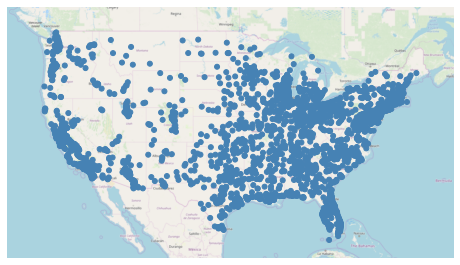

In [9]:
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator())
gplt.pointplot(continental_usa_cities, ax=ax)

This is a static webmap. Interactive (scrolly-panny) webmaps are also possible: [see the demo](https://residentmario.github.io/geoplot/gallery/plot_boston_airbnb_kde.html) for an example of one.

This map tells us that there are more cities on either coast than there are in and around the Rocky Mountains, but it doesn't tell us anything about the cities themselves. We can make an informative plot by adding `hue` to the plot:

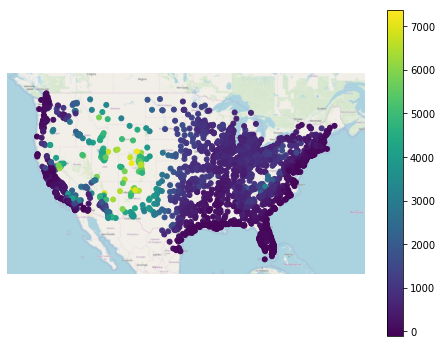

In [10]:
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator())
gplt.pointplot(continental_usa_cities, ax=ax, hue='ELEV_IN_FT', legend=True)

This map tells a clear story: that cities in the central United States have a higher `ELEV_IN_FT` then most other cities in the United States, especially those on the coast. Toggling the legend on helps make this result more interpretable.

To use a different [colormap](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html), use the `cmap` parameter:

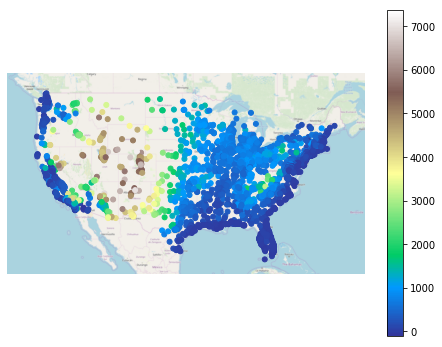

In [11]:
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator())
gplt.pointplot(continental_usa_cities, ax=ax, hue='ELEV_IN_FT', cmap='terrain', legend=True)

`geoplot` comes equipped with a broad variety of visual options which can be tuned to your liking.

/Users/alex/miniconda3/envs/geoplot-dev/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Cities in the Continental United States by Elevation')

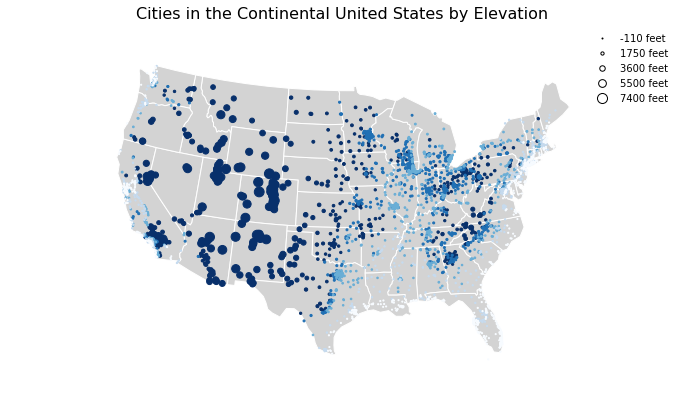

In [12]:
ax = gplt.polyplot(
    contiguous_usa, projection=gcrs.AlbersEqualArea(),
    edgecolor='white', facecolor='lightgray',
    figsize=(12, 8)
)
gplt.pointplot(
    continental_usa_cities, ax=ax, hue='ELEV_IN_FT', cmap='Blues',
    scheme='quantiles',
    scale='ELEV_IN_FT', limits=(1, 10),    
    legend=True, legend_var='scale',
    legend_kwargs={'frameon': False},
    legend_values=[-110, 1750, 3600, 5500, 7400],
    legend_labels=['-110 feet', '1750 feet', '3600 feet', '5500 feet', '7400 feet']   
)
ax.set_title('Cities in the Continental United States by Elevation', fontsize=16)

Let's look at a couple of other plot types available in `geoplot` (for the full list, see the [Plot Reference](https://residentmario.github.io/geoplot/plot_references/plot_reference.html)).

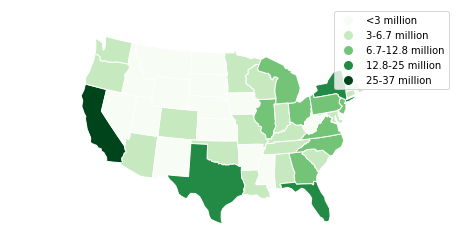

In [13]:
gplt.choropleth(
    contiguous_usa, hue='population', projection=gcrs.AlbersEqualArea(),
    edgecolor='white', linewidth=1,
    cmap='Greens', legend=True,
    scheme='FisherJenks',
    legend_labels=[
        '<3 million', '3-6.7 million', '6.7-12.8 million',
        '12.8-25 million', '25-37 million'
    ]
)

This `choropleth` of population by state shows how much larger certain coastal states are than their peers in the central United States. A `choropleth` is the standard-bearer in cartography for showing information about areas because it's easy to make and interpret.

/Users/alex/miniconda3/envs/geoplot-dev/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


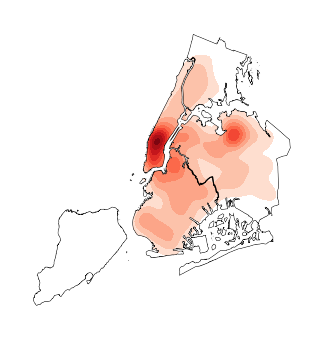

In [14]:
boroughs = gpd.read_file(gplt.datasets.get_path('nyc_boroughs'))
collisions = gpd.read_file(gplt.datasets.get_path('nyc_collision_factors'))

ax = gplt.kdeplot(collisions, cmap='Reds', shade=True, clip=boroughs, projection=gcrs.AlbersEqualArea())
gplt.polyplot(boroughs, zorder=1, ax=ax)

A `kdeplot` smoothes point data out into a heatmap. This makes it easy to spot regional trends in your input data. The `clip` parameter can be used to clip the resulting plot to the surrounding geometry&mdash;in this case, the outline of New York City.

You should now know enough `geoplot` to try it out in your own projects!

To install `geoplot`, run `conda install geoplot`. To see more examples using `geoplot`, check out the [Gallery](https://residentmario.github.io/geoplot/gallery/index.html).